In [1]:
import re
import numpy as np
import spacy
import pandas as pd

In [2]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tqdm

In [5]:
import imp

tools = imp.load_source('tools', '../lda_tools.py')

In [ ]:
import matplotlib
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

**The entire data and the two models**

In [6]:
df = pd.read_csv('../data/prisoners_dilemma_articles_meta_data_clean.csv')

In [7]:
data = df[['abstract', 'unique_key', 'title', 'date']]

In [8]:
data = data.drop_duplicates()

In [9]:
data = data.reset_index(drop=True)

**parameters fix**

In [10]:
words = list(tools.sentences_to_words(data['abstract'].values))

In [11]:
from nltk.corpus import stopwords

In [12]:
stop_words = stopwords.words('english')

In [13]:
lemmatized_words = tools.clean_words(words, stop_words)

In [14]:
id2word = corpora.Dictionary(lemmatized_words)

texts = lemmatized_words

corpus = [id2word.doc2bow(text) for text in texts]

**models**

In [15]:
mallet_path = '/Users/storm/rsc/mallet-2.0.8/bin/mallet'

In [16]:
limit = 7

In [17]:
model_list, coherence_values = tools.compute_coherence_values(limit=limit,
                                                              step=1,
                                                              start=5,
                                                              mallet_path=mallet_path,
                                                              dictionary=id2word,
                                                              corpus=corpus,
                                                              texts=lemmatized_words)

In [18]:
model_list[0].print_topics()

[(0,
  '0.040*"social" + 0.031*"behavior" + 0.018*"human" + 0.016*"study" + 0.013*"experiment" + 0.012*"cooperative" + 0.011*"cooperation" + 0.010*"suggest" + 0.009*"find" + 0.009*"behaviour"'),
 (1,
  '0.027*"individual" + 0.025*"group" + 0.015*"good" + 0.012*"show" + 0.012*"high" + 0.012*"increase" + 0.011*"punishment" + 0.011*"cost" + 0.011*"result" + 0.009*"benefit"'),
 (2,
  '0.092*"game" + 0.073*"strategy" + 0.047*"player" + 0.036*"agent" + 0.025*"dilemma" + 0.020*"play" + 0.015*"payoff" + 0.015*"state" + 0.012*"prisoner" + 0.012*"equilibrium"'),
 (3,
  '0.061*"cooperation" + 0.043*"network" + 0.030*"population" + 0.026*"evolutionary" + 0.024*"evolution" + 0.022*"interaction" + 0.020*"dynamic" + 0.017*"structure" + 0.016*"cooperator" + 0.015*"study"'),
 (4,
  '0.034*"model" + 0.023*"theory" + 0.019*"base" + 0.016*"system" + 0.012*"problem" + 0.012*"paper" + 0.011*"propose" + 0.011*"information" + 0.010*"provide" + 0.009*"approach"')]

In [19]:
model_list[1].print_topics()

[(0,
  '0.039*"population" + 0.028*"evolutionary" + 0.026*"dynamic" + 0.021*"model" + 0.014*"selection" + 0.013*"result" + 0.011*"evolution" + 0.011*"evolve" + 0.011*"show" + 0.010*"process"'),
 (1,
  '0.105*"game" + 0.084*"strategy" + 0.053*"player" + 0.041*"agent" + 0.021*"play" + 0.018*"dilemma" + 0.016*"state" + 0.014*"prisoner" + 0.014*"payoff" + 0.013*"equilibrium"'),
 (2,
  '0.024*"behavior" + 0.022*"social" + 0.019*"human" + 0.018*"decision" + 0.016*"study" + 0.016*"experiment" + 0.013*"make" + 0.013*"suggest" + 0.011*"result" + 0.011*"behaviour"'),
 (3,
  '0.090*"cooperation" + 0.055*"network" + 0.024*"interaction" + 0.021*"structure" + 0.021*"study" + 0.019*"evolution" + 0.016*"find" + 0.014*"behavior" + 0.014*"cooperative" + 0.014*"simulation"'),
 (4,
  '0.033*"model" + 0.027*"theory" + 0.017*"system" + 0.015*"base" + 0.015*"paper" + 0.014*"problem" + 0.013*"propose" + 0.011*"present" + 0.011*"approach" + 0.011*"provide"'),
 (5,
  '0.048*"individual" + 0.030*"group" + 0.018*

**Coherance value of models**

In [20]:
coherence_values

[0.406455703185328, 0.4180270524622777]

**Median contributions**

In [21]:
model_contributions = []
for model in model_list:
    contributions = []
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        contributions.append(row[0][-1])
    model_contributions.append(contributions)

In [22]:
[np.median(contribution) for contribution in model_contributions]

[0.3275862068965517, 0.29171390778533635]

Run models with topics 5 and 6 over the temporal data sets.

In [23]:
years = sorted(data.date.unique())
periods = np.linspace(min(years), max(years), 10)
periods = periods[2:]

In [24]:
model_highest_contributions = []
for year in tqdm.tqdm(periods):
    if year == int(2018):
        yearly_data = data
    else:
        yearly_data = data[data['date'] <= int(year)]
    yearly_words = list(tools.sentences_to_words(yearly_data['abstract'].values))
    yearly_lemmatized_words = tools.clean_words(yearly_words, stop_words)
    
    to_fit = [id2word.doc2bow(text) for text in yearly_lemmatized_words]
    
    models_contribution = []
    models_coh_val = []

    for model in model_list:
        contributions = []
        for i, row in enumerate(model[to_fit]):
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            contributions.append(row[0][-1])
            
        models_contribution.append(contributions)
    
    model_highest_contributions.append(models_contribution)

100%|██████████| 8/8 [01:59<00:00, 14.92s/it]


**Temporal**

In [25]:
number_of_topics_per_year = [5, 13, 13, 14, 14, 3, 3, 6]

In [26]:
highest_percentage_contributions_over_time = []
coherance_values_over_time = []
for year, num_topics in tqdm.tqdm(zip(periods, number_of_topics_per_year)):
    if year == int(2018):
        yearly_data = data
    else:
        yearly_data = data[data['date'] <= int(year)]
    
    yearly_words = list(tools.sentences_to_words(yearly_data['abstract'].values))
    yearly_lemmatized_words = tools.clean_words(yearly_words, stop_words)
    
    dictionary = corpora.Dictionary(yearly_lemmatized_words)
    yearly_corpus = [dictionary.doc2bow(text) for text in yearly_lemmatized_words]
    
    model = gensim.models.wrappers.LdaMallet(
            mallet_path,
            corpus=yearly_corpus,
            num_topics=num_topics,
            id2word=dictionary,
            random_seed=100
        )
    
    contributions = []
    for i, row in enumerate(model[yearly_corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        contributions.append(row[0][-1])
    
    coherencemodel = CoherenceModel(
            model=model, texts=yearly_lemmatized_words, dictionary=dictionary, coherence="c_v"
        )
    coherance_values_over_time.append(coherencemodel.get_coherence())
    highest_percentage_contributions_over_time.append(contributions)

8it [06:18, 47.27s/it]


In [27]:
contr_model_fiv, contr_model_six = zip(*model_highest_contributions)

In [28]:
median_contr_models_over_time = [np.median(vals) for vals in highest_percentage_contributions_over_time]

In [29]:
median_contr_model_fiv = [np.median(vals) for vals in contr_model_fiv]
median_contr_model_six = [np.median(vals) for vals in contr_model_six]

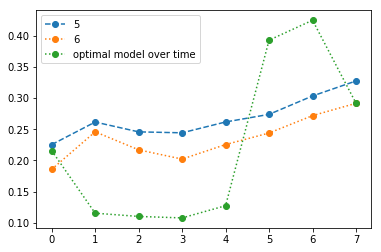

In [30]:
fig, axes = plt.subplots()

axes.plot(median_contr_model_fiv, '--o', label='5')
axes.plot(median_contr_model_six, ':o', label='6')
axes.plot(median_contr_models_over_time, ':o', label='optimal model over time')

axes.legend();

In [31]:
min_contr_model_fiv = [min(vals) for vals in contr_model_fiv]
min_contr_model_six = [min(vals) for vals in contr_model_six]
min_contr_models_over_time = [min(vals) for vals in highest_percentage_contributions_over_time]

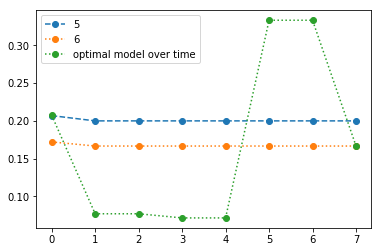

In [32]:
fig, axes = plt.subplots()

axes.plot(min_contr_model_fiv, '--o', label='5')
axes.plot(min_contr_model_six, ':o', label='6')
axes.plot(min_contr_models_over_time, ':o', label='optimal model over time')


axes.legend();

In [33]:
max_contr_model_fiv = [max(vals) for vals in contr_model_fiv]
max_contr_model_six = [max(vals) for vals in contr_model_six]
max_contr_models_over_time = [max(vals) for vals in highest_percentage_contributions_over_time]

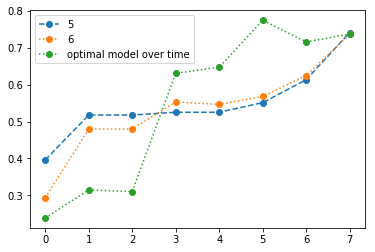

In [34]:
fig, axes = plt.subplots()

axes.plot(max_contr_model_fiv, '--o', label='5')
axes.plot(max_contr_model_six, ':o', label='6')
axes.plot(max_contr_models_over_time, ':o', label='optimal model over time')

axes.legend();

In [46]:
median_percentage_contributions_over_time_ratio = [val / (1 / number_of_topics_per_year[i])
                                                   for i, val in enumerate(median_contr_models_over_time)]

In [47]:
contr_model_fiv_ratio = [val / (1 / 5) for val in median_contr_model_fiv]
contr_model_six_ratio = [val / (1 / 6) for val in median_contr_model_six]

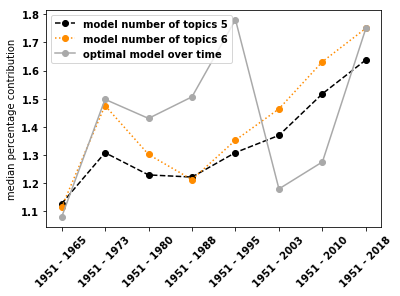

In [50]:
fig, axes = plt.subplots()

axes.plot(contr_model_fiv_ratio, '--o', label='model number of topics 5', color='black')
axes.plot(contr_model_six_ratio, ':o', label='model number of topics 6', color='darkorange')
axes.plot(median_percentage_contributions_over_time_ratio, '-o', label='optimal model over time', color='darkgray')

axes.legend();

axes.set_ylabel('median percentage contribution');

axes.set_xticks(range(0, 8))
axes.set_xticklabels([f'1951 - {int(year)}' for year in periods], rotation=45);

# plt.savefig("../../assets/images/contribution_over_time.pdf",
#                 bbox_inches="tight")

In [57]:
colors = ['black', 'darkorange', 'darkgray', 'red']

In [58]:
data = [contr_model_fiv, contr_model_six, highest_percentage_contributions_over_time, [0]]

In [100]:
titles = [r'$c^* \times n$ Distribution for LDA $n=5$',
          r'$c^* \times n$ Distribution for LDA $n=6$',
          r'$c^* \times n$ Distribution for LDA optimal number of topics',
          r'$\bar{c}^* \times n$ for LDA models']

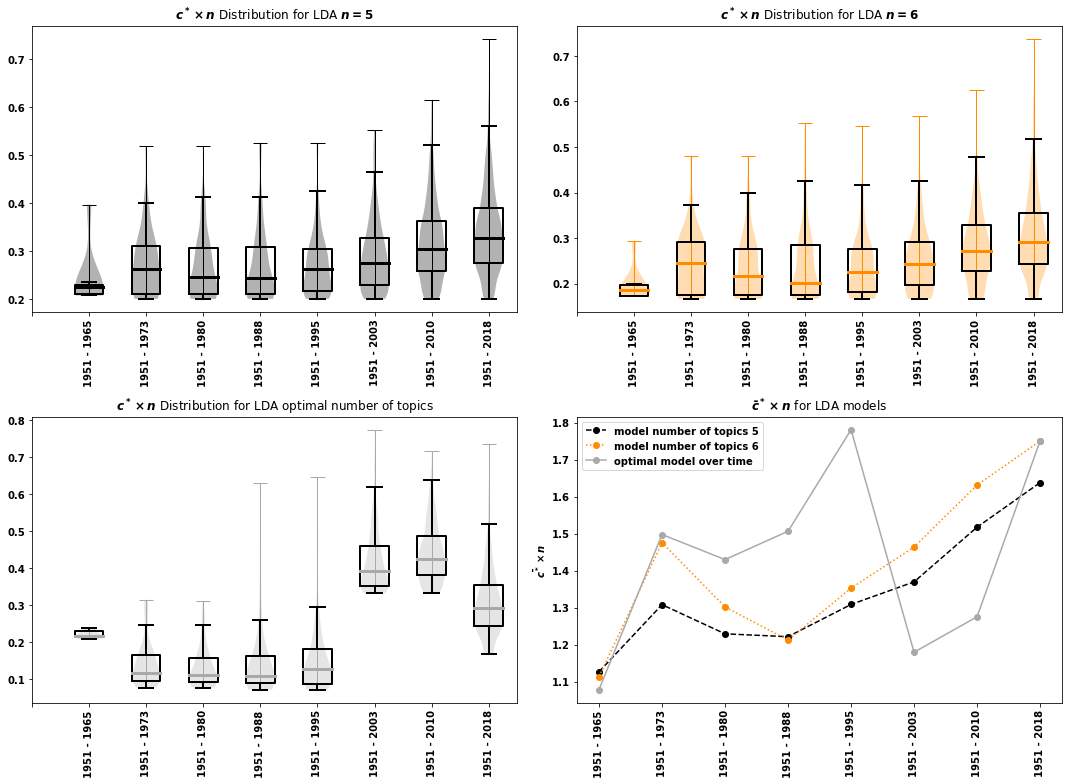

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for i, measure in enumerate(data):
    index = (int(i / 2), i % 2)
    if i == 3:
        axes[index].plot(contr_model_fiv_ratio, '--o', label='model number of topics 5', color='black')
        axes[index].plot(contr_model_six_ratio, ':o', label='model number of topics 6', color='darkorange')
        axes[index].plot(median_percentage_contributions_over_time_ratio, '-o',
                         label='optimal model over time', color='darkgray')
        axes[index].set_xticks(range(0, 8))
        axes[index].set_xticklabels([f'1951 - {int(year)}' for year in periods], rotation=90);
        
        axes[index].legend();

        axes[index].set_ylabel(r'$\bar{c^*} \times n$');
    else:
        violin_parts = axes[index].violinplot(measure,)
        boxes = axes[index].boxplot(measure, showfliers=False)

        for partname in ('cbars','cmins','cmaxes',):
            vp = violin_parts[partname]
            vp.set_edgecolor(colors[i])
            vp.set_linewidth(1)

        for pc in violin_parts['bodies']:
            pc.set_facecolor(colors[i])
            
        for bp in boxes['medians']:
            bp.set_color(colors[i])
            bp.set_linewidth(3)
        for bp in boxes['caps']:
            bp.set_color('black')
            bp.set_linewidth(2)
        for bp in boxes['whiskers']:
            bp.set_color('black')
            bp.set_linewidth(2)
        for bp in boxes['boxes']:
            bp.set_color('black')
            bp.set_linewidth(2)

        axes[index].set_xticks(range(0, 9))
        axes[index].set_xticklabels([''] + [f'1951 - {int(year)}' for year in periods], rotation=90);
    axes[index].set_title(titles[i])
fig.tight_layout()

plt.savefig("../../assets/images/contribution_over_time.pdf", bbox_inches="tight")